# Motion Data Analysis and(/or) Classification
Goals:
- explore motion.csv datasets
- test classification schemes to extract different types of motion
  - surfing (riding a wave)
  - floating
  - paddling
  - walking with board
  - motionless
- use different data frequencies to see what is available
- test rolling means, variances, ...

### Imports

In [25]:
# Standard data/datetime manipulations
import pandas as pd
import numpy as np
import os
import datetime
import pytz

# Web scraping
import re
import requests

# Signal Processing
from scipy import stats
import scipy.signal as signal
from scipy.signal import butter, lfilter, freqz

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
import folium
import cmocean

# Show plots in notebook interactively
%matplotlib notebook

### Read data
<del>Using Kat's spreadsheet: https://docs.google.com/spreadsheets/d/1tiL41vJCAJKeqN5N1pvKOrpoubH5X-G3omvjiX3NgXQ/edit#gid=584191940
saved as .xlsx </del>

*There is an **Inventory_Short.xlsx** and unappended **Inventory.xlsx** with fewer and more fins to test* 

For now, just use individual <code>ride_ids</code> to streamline testing


In [26]:
# Get CSV from ride_ids where ride_ids come from fin_ids
ride_ids = ['14636']

### Set up analysis with scraping functions

In [27]:
#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' # OMG I can't believe this is how we're doing this. 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        
    else:
        ocean_df_small = pd.DataFrame() # empty DF just so something is returned
        motion_df_small = pd.DataFrame() 
    
    return ocean_df_small, motion_df_small

### Build dataframes with appended session files

In [28]:
#%% Append new DataFrames (motion and ocean) into list
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

# Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above

        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride ", rid, "so far so good")
            count_good_fins += 1
    except: 
        print("Ride ", rid, " ain't workin'")    


https://surf.smartfin.org/ride/14636
https://surf.smartfin.org/media/201806/google_101440910315486450418_000666D321BE_180624160430_Ocean.CSV
Ride  14636 so far so good


### Set up Filters

In [29]:
#%% Filter out noisy data
# Filter requirements
order = 6
fs = 5       # sample rate, Hz
cutoff = 1  # desired cutoff frequency of the filter, Hz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

### Concatenate dataframes into one

In [30]:
#%% Build the "Master" DataFrame
# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, whatever that means
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])
ocean_df.head()

UTC        Time  Temperature 1  \
ride_id                                                        
14636   0 2018-06-24 16:04:39.487  3097968316            337   
        1 2018-06-24 16:04:45.533  3097974336            338   
        2 2018-06-24 16:04:51.579  3097980356            338   
        3 2018-06-24 16:04:57.625  3097986376            338   
        4 2018-06-24 16:05:03.671  3097992396            339   

           Calibrated Temperature 1  Temperature 1 Stable  Temperature 2  \
ride_id                                                                    
14636   0                    21.062                 False           5173   
        1                    21.125                 False           5181   
        2                    21.125                 False           5182   
        3                    21.125                 False           5199   
        4                    21.188                 False           5213   

           Calibrated Temperature 2  Temperature 2 Stable  salinity  \
ride_id                                                               
14636   0                    20.365                 False       NaN   
        1                    20.396                 False       NaN   
        2                    20.400                 False       NaN   
        3                    20.467                 False       NaN   
        4                    20.522                 False       NaN   

           Calibrated Salinity  Salinity Stable  pH  Calibrated pH  pH Stable  
ride_id                                                                        
14636   0                  NaN              NaN NaN            NaN        NaN  
        1                  NaN              NaN NaN            NaN        NaN  
        2                  NaN              NaN NaN            NaN        NaN  
        3                  NaN              NaN NaN            NaN        NaN  
        4                  NaN              NaN NaN            NaN        NaN

In [31]:
motion_df.tail()

UTC        Time  IMU A1  IMU A2  IMU A3  \
ride_id                                                                     
14636   18066 2018-06-24 17:15:51.056  3102221583   491.0    19.0    58.0   
        18067 2018-06-24 17:15:51.307  3102221833   498.0   185.0    63.0   
        18068 2018-06-24 17:15:51.558  3102222083   491.0    31.0    61.0   
        18069 2018-06-24 17:15:51.810  3102222334   491.0    16.0    57.0   
        18070 2018-06-24 17:15:52.053  3102222576   492.0    14.0    57.0   

               IMU G1  IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  Latitude  \
ride_id                                                                   
14636   18066   -15.0   -11.0    13.0   -28.0   286.0   394.0       NaN   
        18067    34.0    -9.0    21.0   -24.0   294.0   396.0       NaN   
        18068   -15.0    -7.0    11.0   -30.0   290.0   390.0       NaN   
        18069   -18.0   -12.0    24.0   -24.0   290.0   400.0       NaN   
        18070   -17.0   -10.0    21.0   -24.0   286.0   398.0       NaN   

               Longitude  
ride_id                   
14636   18066        NaN  
        18067        NaN  
        18068        NaN  
        18069        NaN  
        18070        NaN

### Subsample
Take every fifth sample from dataframes to attempt to mimic what we'll do with ~ 1 Hz data

In [32]:
motion_df.set_index('UTC', append = True, inplace = True)
motion_df.head()

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id   UTC                                                                   
14636   0 2018-06-24 16:04:39.948  3097968775   -34.0    46.0   501.0   -16.0   
        1 2018-06-24 16:04:40.199  3097969025   -33.0    49.0   502.0   -14.0   
        2 2018-06-24 16:04:40.451  3097969276   -33.0    45.0   501.0   -14.0   
        3 2018-06-24 16:04:40.702  3097969526   -33.0    42.0   501.0   -14.0   
        4 2018-06-24 16:04:40.955  3097969778   -34.0    46.0   501.0   -15.0   

                                   IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id   UTC                                                               
14636   0 2018-06-24 16:04:39.948   -14.0    30.0   150.0   288.0   114.0   
        1 2018-06-24 16:04:40.199   -11.0    19.0   158.0   290.0   104.0   
        2 2018-06-24 16:04:40.451   -11.0    16.0   154.0   288.0   112.0   
        3 2018-06-24 16:04:40.702   -10.0    17.0   152.0   288.0   112.0   
        4 2018-06-24 16:04:40.955   -10.0    17.0   152.0   300.0   118.0   

                                   Latitude  Longitude  
ride_id   UTC                                           
14636   0 2018-06-24 16:04:39.948       NaN        NaN  
        1 2018-06-24 16:04:40.199       NaN        NaN  
        2 2018-06-24 16:04:40.451       NaN        NaN  
        3 2018-06-24 16:04:40.702       NaN        NaN  
        4 2018-06-24 16:04:40.955       NaN        NaN

### Regroup to resample by datetimeindex
If you only do the groupby('1s').sum() operation, then it will lose the multiindex which is worth preserving here

In [35]:
level_values = motion_df.index.get_level_values
motion1s_df = motion_df.groupby([level_values(i) for i in [0,1]]
                                +[pd.Grouper(freq='1s', level=-1)]).last()

# NaNs break spectral calcs
motion1s_df = pd.DataFrame(motion_df)
motion1s_df.interpolate(inplace = True) 
motion1s_df.tail(20)

Time  IMU A1  IMU A2  IMU A3  \
ride_id       UTC                                                           
14636   18051 2018-06-24 17:15:47.541  3102218083   481.0    19.0    62.0   
        18052 2018-06-24 17:15:47.792  3102218333   484.0    33.0    81.0   
        18053 2018-06-24 17:15:48.000  3102218540   486.5    24.5    75.0   
        18054 2018-06-24 17:15:48.037  3102218577   489.0    16.0    69.0   
        18055 2018-06-24 17:15:48.288  3102218827   489.0     6.0    65.0   
        18056 2018-06-24 17:15:48.540  3102219078   491.0    14.0    65.0   
        18057 2018-06-24 17:15:48.791  3102219328   491.0    13.0    65.0   
        18058 2018-06-24 17:15:49.043  3102219579   491.0     9.0    64.0   
        18059 2018-06-24 17:15:49.295  3102219829   490.0     5.0    62.0   
        18060 2018-06-24 17:15:49.548  3102220081   490.0     5.0    63.0   
        18061 2018-06-24 17:15:49.799  3102220331   491.0    15.0    60.0   
        18062 2018-06-24 17:15:50.051  3102220582   491.0    16.0    63.0   
        18063 2018-06-24 17:15:50.302  3102220832   491.0    13.0    58.0   
        18064 2018-06-24 17:15:50.554  3102221083   491.0    22.0    61.0   
        18065 2018-06-24 17:15:50.805  3102221333   490.0    15.0    59.0   
        18066 2018-06-24 17:15:51.056  3102221583   491.0    19.0    58.0   
        18067 2018-06-24 17:15:51.307  3102221833   498.0   185.0    63.0   
        18068 2018-06-24 17:15:51.558  3102222083   491.0    31.0    61.0   
        18069 2018-06-24 17:15:51.810  3102222334   491.0    16.0    57.0   
        18070 2018-06-24 17:15:52.053  3102222576   492.0    14.0    57.0   

                                       IMU G1  IMU G2  IMU G3  IMU M1  IMU M2  \
ride_id       UTC                                                               
14636   18051 2018-06-24 17:15:47.541     0.0   -45.0    -4.0   -33.0   297.0   
        18052 2018-06-24 17:15:47.792   -61.0    -3.0   -29.0   -30.0   288.0   
        18053 2018-06-24 17:15:48.000   -39.5    -6.5    -2.5   -30.5   289.5   
        18054 2018-06-24 17:15:48.037   -18.0   -10.0    24.0   -31.0   291.0   
        18055 2018-06-24 17:15:48.288   -13.0   -10.0    23.0   -34.0   286.0   
        18056 2018-06-24 17:15:48.540   -15.0   -15.0    16.0   -34.0   294.0   
        18057 2018-06-24 17:15:48.791   -15.0   -15.0    26.0   -28.0   288.0   
        18058 2018-06-24 17:15:49.043   -15.0   -16.0    24.0   -24.0   290.0   
        18059 2018-06-24 17:15:49.295   -14.0   -13.0    18.0   -26.0   292.0   
        18060 2018-06-24 17:15:49.548   -14.0   -15.0    12.0   -31.0   297.0   
        18061 2018-06-24 17:15:49.799    -7.0   -16.0     3.0   -29.0   293.0   
        18062 2018-06-24 17:15:50.051   -14.0   -14.0     7.0   -25.0   289.0   
        18063 2018-06-24 17:15:50.302   -15.0   -13.0    18.0   -28.0   288.0   
        18064 2018-06-24 17:15:50.554   -15.0    -8.0    11.0   -25.0   291.0   
        18065 2018-06-24 17:15:50.805   -11.0   -12.0    10.0   -27.0   297.0   
        18066 2018-06-24 17:15:51.056   -15.0   -11.0    13.0   -28.0   286.0   
        18067 2018-06-24 17:15:51.307    34.0    -9.0    21.0   -24.0   294.0   
        18068 2018-06-24 17:15:51.558   -15.0    -7.0    11.0   -30.0   290.0   
        18069 2018-06-24 17:15:51.810   -18.0   -12.0    24.0   -24.0   290.0   
        18070 2018-06-24 17:15:52.053   -17.0   -10.0    21.0   -24.0   286.0   

                                       IMU M3      Latitude     Longitude  
ride_id       UTC                                                          
14636   18051 2018-06-24 17:15:47.541   393.0  3.312904e+06 -1.173341e+07  
        18052 2018-06-24 17:15:47.792   394.0  3.312904e+06 -1.173341e+07  
        18053 2018-06-24 17:15:48.000   395.5  3.312904e+06 -1.173341e+07  
        18054 2018-06-24 17:15:48.037   397.0  3.312904e+06 -1.173341e+07  
        18055 2018-06-24 17:15:48.288   392.0  3.312904e+06 -1.173341e+07  
        18056 2018-06-24 17:15:48.5

plotting the  14636  stuff


<IPython.core.display.Javascript object>


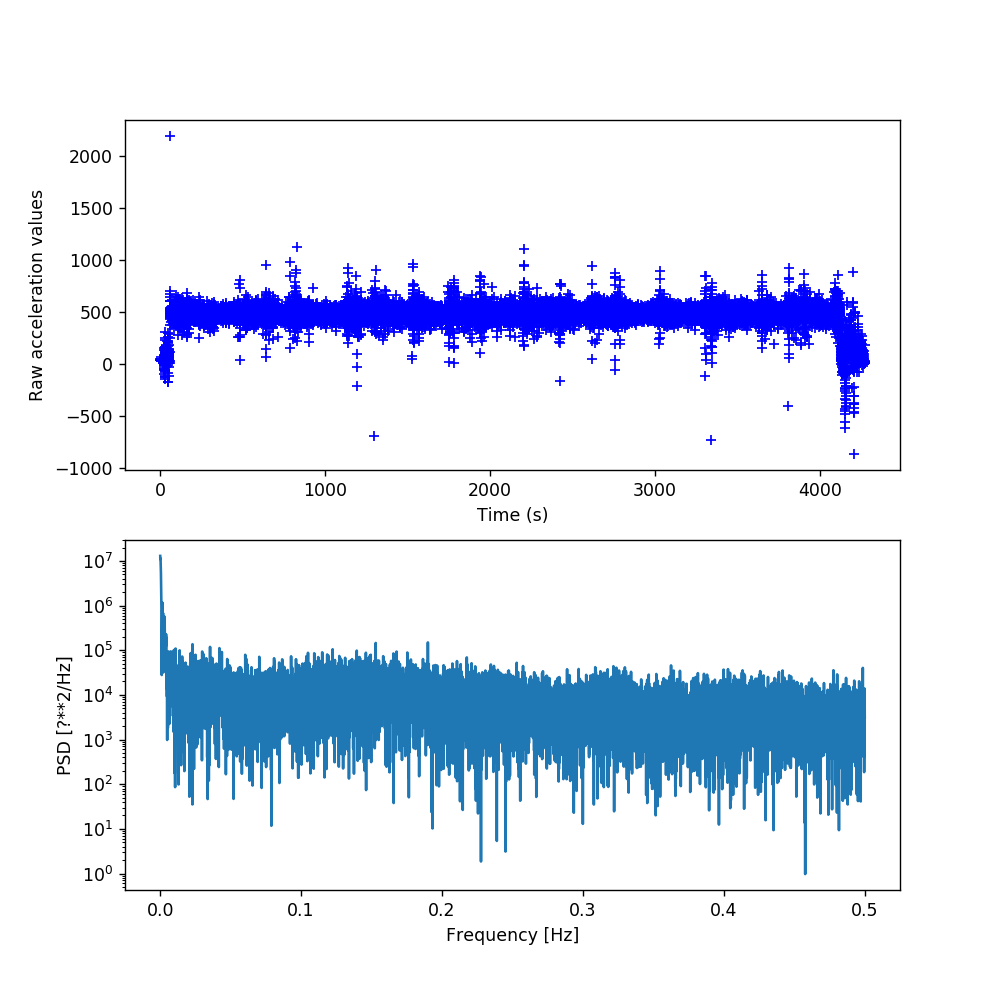

In [37]:
#%% Plotify
good_rides = (motion1s_df.index.get_level_values(0).unique()) # get all names
n_rides = len(good_rides)

# Make plot of each good session (ride)
for n in range(0, n_rides): 
    print("plotting the ", good_rides[n], " stuff")
    
    # Subset based on individual ride
    this_ride = good_rides[n]
    this_ride_motion_df = motion1s_df.xs(good_rides[n], level = 'ride_id', axis = 0)
#     print(this_ride_motion_df.head())
    
# #    this_filled = this_ride_motion_df.fillna(0)
#     accel_prefilt = this_ride_motion_df['IMU A2']
#     simple_filter = (accel_prefilt > 200) & (accel_prefilt < 800) 
#     this_filt1 = this_ride_motion_df[simple_filter]
# #     print(this_filt1.head())
#     accel_filt1 = this_filt1['IMU A2']
    
    try:

        # Grab elapsed time (x) and acceleration (y)
        datetime = this_ride_motion_df.index.get_level_values(-1)
        elapsed = datetime-datetime[0]
        elapsed_sec = np.asarray(elapsed/np.timedelta64(1, 's'))
        y = np.asarray(this_ride_motion_df['IMU A2'])
        
        # PSD doesn't work on NaN-filled vectors
        good_vals = ~np.isnan(y)
        y = y[good_vals]
        elapsed_sec = elapsed_sec[good_vals]

        # Plot
        fig, axs = plt.subplots(2, 1, figsize = (8, 8))
        
        axs[0].plot(elapsed_sec, y, 'b+') # actual time-series
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('Raw acceleration values')
        
        # Calculate PSD and plot
        freq_sample = 1 # forced to 1 Hz above
        f, Pxx_den = signal.periodogram(y, freq_sample)
        
        
        axs[1].semilogy(f[1:], Pxx_den[1:]) # don't start at 1st value (index 0) with a value of 0
#         plt.ylim([1e-7, 1e2])
        axs[1].set_xlabel('Frequency [Hz]')
        axs[1].set_ylabel('PSD [?**2/Hz]')
        
    except Exception as e:
        print(e)